# Toy Model Implementation

In [1]:
import os

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import torch

import plotnine as p9

sclembas_path = 'LEMBAS'
import sys
sys.path.insert(1, os.path.join(sclembas_path))
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [2]:
n_cores = 12
utils.set_cores(n_cores)

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Input Data

In [3]:
# Prior knowledge signaling network
net = pd.read_csv('data/KEGGnet-Model.tsv', sep = '\t', index_col = False)

# Synthetic data input and output
x_data = pd.read_csv(os.path.join('data', 'synthetic_data_x_50.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'synthetic_data_xcell_50.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'synthetic_data_xdrug_comb_50.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'synthetic_data_y_scaled_50.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)

# X_validation set
x_data_val = pd.read_csv(os.path.join('data', 'synthetic_data_x_test_50.csv'), sep=',', low_memory=False, index_col=0)
x_cell_val = pd.read_csv(os.path.join('data', 'synthetic_data_xcell_test_50.csv'), sep=',', low_memory=False, index_col=0)
y_data_val = pd.read_csv(os.path.join('data', 'synthetic_data_y_test_50.csv'), sep=',', low_memory=False, index_col=0)

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.head())
display(nodes_sites_map.head())

,D1,D11,D13,D14,D15,D16,D17,D21,D22,D23,...,D82,D84,D85,D89,D9,D91,D93,D96,D97,DMSO
Drug_CL,,,,,,,,,,,,,,,,,,,,,
D26_CL0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL1,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL3,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL4,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL5,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,CL0,CL1,CL3,CL4,CL5,CL6
Drug_CL,,,,,,
D26_CL0,1,0,0,0,0,0
D26_CL1,0,1,0,0,0,0
D26_CL3,0,0,1,0,0,0
D26_CL4,0,0,0,1,0,0
D26_CL5,0,0,0,0,1,0


,D1,D11,D13,D14,D15,D16,D17,D21,D22,D23,...,D82,D84,D85,D89,D9,D91,D93,D96,D97,DMSO
O14511,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O43557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O75326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O96014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


,O14492_site_1,O14511_site_1,O14640_site_1,O14733_site_1,O14733_site_2,O14733_site_3,O14733_site_4,O14763_site_1,O14763_site_2,O14763_site_3,...,Q9Y4K3_site_3,Q9Y4K3_site_4,Q9Y6K9_site_1,Q9Y6K9_site_2,Q9Y6K9_site_3,Q9Y6N7_site_1,Q9Y6N7_site_2,Q9Y6N7_site_3,Q9Y6N7_site_4,Q9Y6N7_site_5
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D26_CL0_0,0.014364,NaN,0.0,0.000000,0.0,NaN,0.000000,NaN,0.0,0.0,...,0.055265,0.073090,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
D26_CL1_0,0.014361,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,...,0.038262,0.050740,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
D26_CL3_0,NaN,0.017613,0.0,0.000000,NaN,0.000000,0.000000,NaN,0.0,NaN,...,0.081828,0.107769,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0
D26_CL4_0,NaN,0.017613,0.0,0.000000,NaN,NaN,0.000000,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0
D26_CL5_0,0.014364,0.017613,0.0,0.002816,NaN,0.002978,0.007411,NaN,0.0,0.0,...,0.343372,0.436144,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


,O14492,O14511,O14640,O14733,O14763,O14788,O14920,O14944,O15169,O15211,...,Q9ULW2,Q9UMX1,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4K3,Q9Y6K9,Q9Y6N7
Phosphosite,,,,,,,,,,,,,,,,,,,,,
O14492_site_1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14511_site_1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14640_site_1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14733_site_1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O14733_site_2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
'''def filter_keep_CL0(df, index_sep='_', cell_line_pos=1):
    """
    Splits the index on `index_sep`, keeps only rows where the cell line (at position `cell_line_pos`)
    equals "CL0", and then re-joins the split parts to form the original index format,
    preserving the original index name.
    """
    index_name = df.index.name  # Store the original index name
    temp = df.index.to_series().str.split(index_sep, expand=True)
    # Filter and keep "CL0"
    mask = temp[cell_line_pos] == "CL0"
    df_filtered = df[mask].copy()
    
    df_filtered.index = temp.loc[mask].apply(lambda row: index_sep.join(row), axis=1)
    df_filtered.index.name = index_name
    return df_filtered

x_data = filter_keep_CL0(x_data, index_sep='_', cell_line_pos=1)
x_cell = filter_keep_CL0(x_cell, index_sep='_', cell_line_pos=1)
y_data = filter_keep_CL0(y_data, index_sep='_', cell_line_pos=1)

display(x_data.head())
display(x_cell.head())
display(y_data.head())'''

'def filter_keep_CL0(df, index_sep=\'_\', cell_line_pos=1):\n    """\n    Splits the index on `index_sep`, keeps only rows where the cell line (at position `cell_line_pos`)\n    equals "CL0", and then re-joins the split parts to form the original index format,\n    preserving the original index name.\n    """\n    index_name = df.index.name  # Store the original index name\n    temp = df.index.to_series().str.split(index_sep, expand=True)\n    # Filter and keep "CL0"\n    mask = temp[cell_line_pos] == "CL0"\n    df_filtered = df[mask].copy()\n    \n    df_filtered.index = temp.loc[mask].apply(lambda row: index_sep.join(row), axis=1)\n    df_filtered.index.name = index_name\n    return df_filtered\n\nx_data = filter_keep_CL0(x_data, index_sep=\'_\', cell_line_pos=1)\nx_cell = filter_keep_CL0(x_cell, index_sep=\'_\', cell_line_pos=1)\ny_data = filter_keep_CL0(y_data, index_sep=\'_\', cell_line_pos=1)\n\ndisplay(x_data.head())\ndisplay(x_cell.head())\ndisplay(y_data.head())'

In [5]:
display(net.head())
#display(condition_input.head())
#display(ligand_input.head())
#display(data_out.head())
#display(tf_output.head())

,source,target,direction,stimulation,inhibition,sources,references
0,O15111,P19838,1,1,0,CancerCellMap;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIM...,CancerCellMap:10469655;CancerCellMap:12482991;...
1,P45985,P45983,1,1,0,ACSN;ELM;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;Inn...,ACSN:11274345;ACSN:12624093;ACSN:12738796;ACSN...
2,Q13009,P63000,1,1,0,ACSN;Adhesome;BioGRID;CA1;HPRD;KEGG;Lit-BM-17;...,ACSN:11955434;ACSN:12829230;ACSN:15611338;ACSN...
3,P01112,Q13009,1,1,0,ACSN;Adhesome;HPRD;InnateDB;KEGG;SPIKE;Wang,ACSN:12134164;ACSN:7673236;ACSN:9069260;Adheso...
4,Q92851,P55957,1,1,0,HPRD;KEGG;SPIKE,HPRD:15772077;SPIKE:16186808


Let's see what the signaling network looks like:

In [6]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
0,O15111,P19838,1,0
1,P45985,P45983,1,0
2,Q13009,P63000,1,0
3,P01112,Q13009,1,0
4,Q92851,P55957,1,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [7]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
0,O15111,P19838,1.0,1,0
1,P45985,P45983,1.0,1,0
2,Q13009,P63000,1.0,1,0
3,P01112,Q13009,1.0,1,0
4,Q92851,P55957,1.0,1,0


## Define Parameters to Build and Train Model

In [8]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 3000, 
             'learning_rate': 2e-3,
             'variable_lr': True}
other_params = {'lambda_dynamic': 1, 'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
module_params = {
    'use_cln': True,
    'cln_hidden_layers': {1: 64, 2: 16},  # {1: 64, 2: 16}
    'use_xssn': True,
    'xssn_hidden_layers': {1: 64, 2: 16},
    'use_time': True,
    'n_timepoints': 8,
    'use_phospho': True,
    'nsl_hidden_layers': None, #{1: 16},
    'conn_dim': None #5
}

hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params, **module_params}  # fed into training function | ** are used to combine multiple dictionaries -> it unpacks them

## Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [9]:
mod = SignalingModel(net = net,
                     X_in = x_data,
                     y_out = y_data, 
                     X_cell = x_cell,
                     X_drug = x_drug,
                     nodes_sites_map = nodes_sites_map,
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     dtype = torch.float32, device = device, seed = seed, module_params = module_params)

#X_in = mod.df_to_tensor(mod.X_in)
#y_out = mod.df_to_tensor(mod.y_out)

In [10]:
mod.X_in.head()

,D1,D11,D13,D14,D15,D16,D17,D21,D22,D23,...,D82,D84,D85,D89,D9,D91,D93,D96,D97,DMSO
Drug_CL,,,,,,,,,,,,,,,,,,,,,
D26_CL0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL1,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL3,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL4,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
D26_CL5,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
mod.y_out.head()

Phosphosite,O14492_site_1,O14511_site_1,O14640_site_1,O14733_site_1,O14733_site_2,O14733_site_3,O14733_site_4,O14763_site_1,O14763_site_2,O14763_site_3,...,Q9Y4K3_site_3,Q9Y4K3_site_4,Q9Y6K9_site_1,Q9Y6K9_site_2,Q9Y6K9_site_3,Q9Y6N7_site_1,Q9Y6N7_site_2,Q9Y6N7_site_3,Q9Y6N7_site_4,Q9Y6N7_site_5
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D26_CL0_0,0.014364,NaN,0.0,0.000000,0.0,NaN,0.000000,NaN,0.0,0.0,...,0.055265,0.073090,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
D26_CL1_0,0.014361,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,...,0.038262,0.050740,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
D26_CL3_0,NaN,0.017613,0.0,0.000000,NaN,0.000000,0.000000,NaN,0.0,NaN,...,0.081828,0.107769,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0
D26_CL4_0,NaN,0.017613,0.0,0.000000,NaN,NaN,0.000000,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0
D26_CL5_0,0.014364,0.017613,0.0,0.002816,NaN,0.002978,0.007411,NaN,0.0,0.0,...,0.343372,0.436144,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


A forward pass looks like this:

In [12]:
# X_in = mod.df_to_tensor(mod.X_in) # ligand inputs
# X_full = mod.input_layer(X_in) # ligand inputs in signaling network
# Y_full = mod.signaling_network(X_full) # signaling network weights
# Y_hat = mod.output_layer(Y_full) # TF outputs of signaling network

## Train Model

In [13]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_train_index, y_train, y_test, y_train_index, X_cell_train, X_cell_test, missing_node_indexes, floor_idx, ceil_idx, weight = train_signaling_model(
    mod, net, optimizer, loss_fn, reset_epoch = 200, hyper_params = hyper_params, train_split_frac = {'train': 0.9, 'test': 0.1}, train_seed = seed, 
    verbose = True, split_by = 'condition', noise_scale = 0.0)

# store results
io.write_pickled_object(stats, os.path.join('data', 'training_stats_cond.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join('data', 'mac_state_dict_cond.pth'))

i=0, l=0.07659, s=0.553, r=0.00020, v=0, Time-mapping index: [0, 14, 27, 39, 49, 58, 66, 72]
i=250, l=0.00105, s=0.392, r=0.00046, v=0, Time-mapping index: [0, 4, 12, 20, 28, 36, 43, 49]
i=500, l=0.00033, s=0.422, r=0.00110, v=0, Time-mapping index: [0, 0, 2, 3, 5, 8, 13, 17]
i=750, l=0.00024, s=0.466, r=0.00174, v=0, Time-mapping index: [0, 0, 2, 2, 5, 10, 15, 20]
i=1000, l=0.00022, s=0.513, r=0.00200, v=0, Time-mapping index: [0, 0, 2, 3, 5, 11, 15, 20]
i=1250, l=0.00021, s=0.517, r=0.00191, v=0, Time-mapping index: [0, 0, 1, 2, 5, 13, 17, 21]
i=1500, l=0.00021, s=0.488, r=0.00166, v=0, Time-mapping index: [0, 0, 2, 3, 5, 14, 18, 22]
i=1750, l=0.00019, s=0.500, r=0.00129, v=0, Time-mapping index: [0, 0, 2, 2, 5, 14, 18, 22]
i=2000, l=0.00017, s=0.478, r=0.00087, v=0, Time-mapping index: [0, 0, 2, 3, 5, 14, 18, 23]
i=2250, l=0.00016, s=0.476, r=0.00048, v=0, Time-mapping index: [0, 0, 2, 2, 4, 15, 19, 23]
i=2500, l=0.00015, s=0.490, r=0.00017, v=0, Time-mapping index: [0, 1, 2, 2, 5, 

## Predict Using Model

In [14]:
mod.load_state_dict(torch.load(os.path.join('data', 'mac_state_dict_cond.pth'), map_location=torch.device('cpu')))
stats = io.read_pickled_object(os.path.join('data', 'training_stats_cond.pickle'))

C:\Users\kanto\AppData\Local\Temp\ipykernel_27288\560733483.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [15]:
X_in = mod.df_to_tensor(mod.X_in)
X_cell = mod.df_to_tensor(mod.X_cell)
X_drug = x_drug
mod.eval()
Y_hat, Y_full, Y_fullFull, Y_fullprotein = mod(X_in, X_cell, missing_node_indexes)  # to know which nodes are missing and should be excluded from the node-site mapping

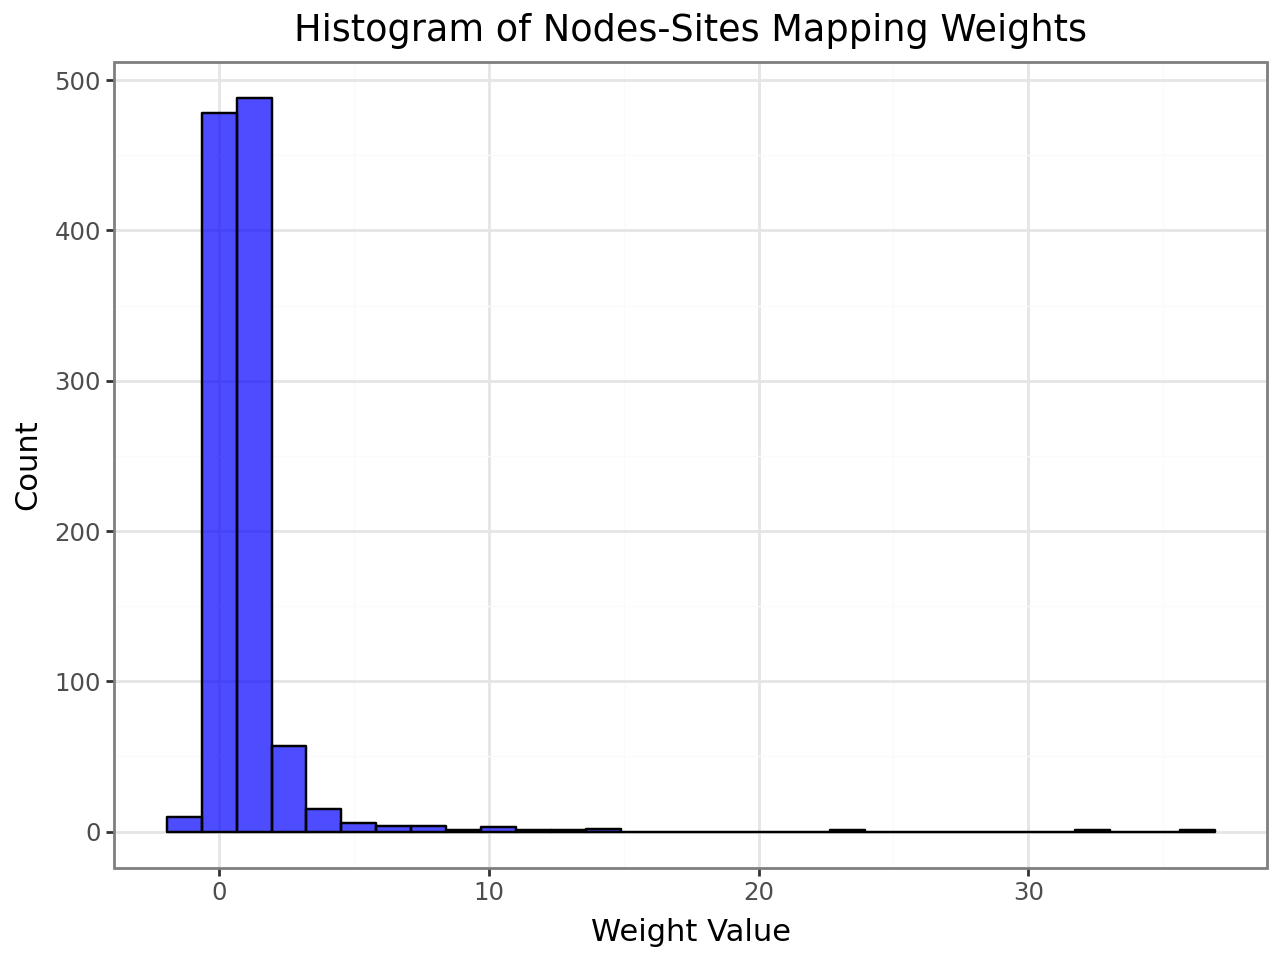

In [16]:
nodes_sites_weights = mod.nodes_sites_layer.real_weights
weights_np = nodes_sites_weights.detach().cpu().numpy().flatten()
df_weights = pd.DataFrame({'Weight': weights_np})

p_hist = (
    p9.ggplot(df_weights, p9.aes(x='Weight')) +
    p9.geom_histogram(bins=30, fill="blue", color="black", alpha=0.7) +
    p9.labs(x="Weight Value", y="Count", title="Histogram of Nodes-Sites Mapping Weights") +
    p9.theme_bw()
)
p_hist.show()

## Visualize

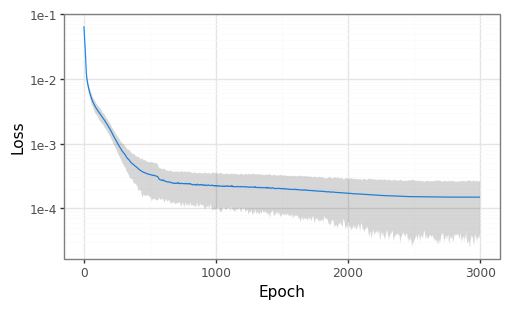

In [17]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
p1A.draw()

As well as how the learning rate was adjusted across training:

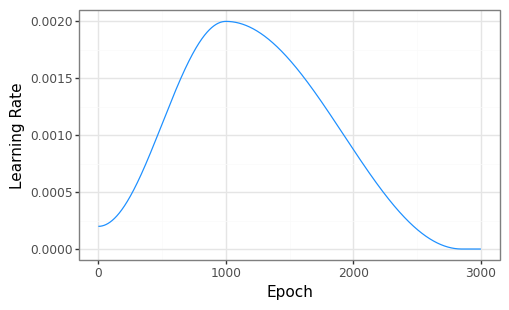

In [18]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

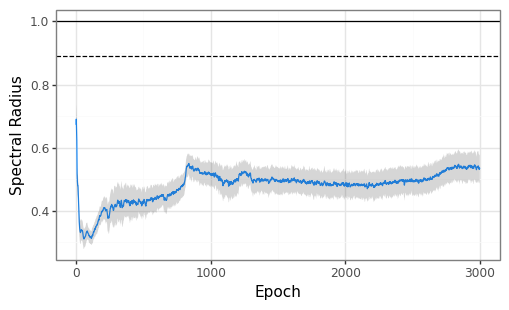

In [19]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

Plot how the time mapping is changing across epochs

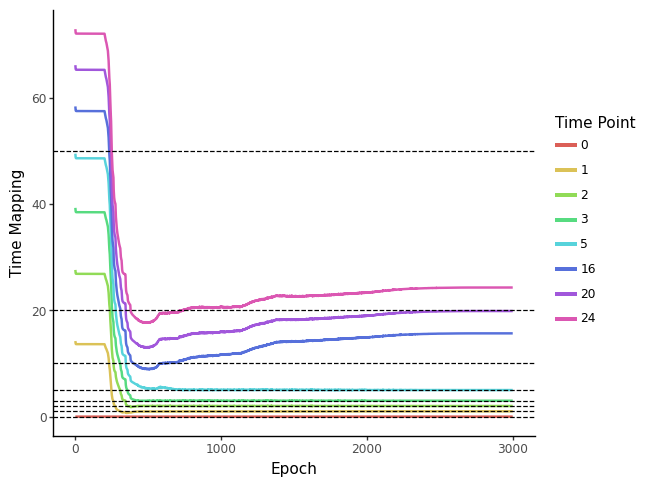

In [20]:
# Prepare the data for plotting
epochs = np.array(range(len(stats['mapping'])))
mapping_data = []

last_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping

for epoch, mapping in enumerate(stats['mapping']):
    for time_point, value in enumerate(mapping):
        time_point_name = last_iteration_mapping[time_point]
        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})

mapping_df = pd.DataFrame(mapping_data)
mapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)

# Real time points
real_time_points = [0, 1, 2, 3, 5, 10, 20, 50]
real_time_df = pd.DataFrame({'Real Time Points': real_time_points})

# Generate a color palette dictionary
color_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))

# Plot using plotnine
p = (
    p9.ggplot(mapping_df, p9.aes(x='Epoch', y='Value', color='Time Point')) +
    p9.geom_line(size=1) +
    p9.geom_hline(p9.aes(yintercept='Real Time Points'), data=real_time_df, color='black', linetype='dashed') +
    p9.scale_color_manual(values=color_palette) +
    p9.labs(x='Epoch', y='Time Mapping', color='Time Point') +
    p9.theme_classic()
)

p.draw()

### Model Benchmarking

Evaluate model. Plot correlation for each site after subtracting the time point zero from the site trajectory for each drug-cell line combination. Plot correlations across sites and across samples. Plot example site trajectory across cell lines and drugs.

torch.Size([2160, 1073]) torch.Size([2160, 1073])


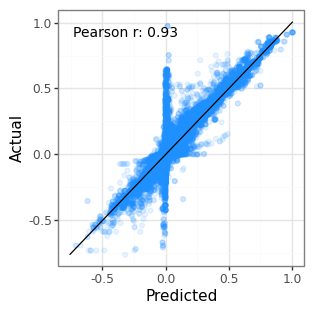

In [21]:
def subsample_Y(Y, floor_idx, ceil_idx, weight):
    """
    Subsample Y using the provided indices and weights.

    Parameters
    ----------
    Y : torch.Tensor
        The tensor to be subsampled.
    floor_idx : torch.Tensor
        The floor indices for subsampling.
    ceil_idx : torch.Tensor
        The ceil indices for subsampling.
    weight : torch.Tensor
        The interpolation weights.

    Returns
    -------
    Y_subsampled : torch.Tensor
        The subsampled tensor.
    """
    Y = Y.to('cpu')
    
    # Reduce dimensions of indices
    floor_idx_reduced = floor_idx[0, :, 0]
    ceil_idx_reduced = ceil_idx[0, :, 0]
    
    # Gather the corresponding hidden state outputs
    Y_floor = Y[:, floor_idx_reduced, :]  # (batch, K, feat)
    Y_ceil = Y[:, ceil_idx_reduced, :]  # (batch, K, feat)
    
    # Perform linear interpolation
    Y_subsampled = (1 - weight) * Y_floor + weight * Y_ceil
    
    return Y_subsampled


y_index = mod.y_out.index.tolist()
y_actual = y_train

Y_hat_train, Y_full_train, Y_fullFull_train, Y_fullprotein_train = mod(X_train, X_cell_train, missing_node_indexes)

#time_points = [int(idx.rsplit('_', 1)[-1]) for idx in y_index]
#seen = set()
#unique_time_points = [x for x in time_points if not (x in seen or seen.add(x))]
#unique_time_points = np.linspace(0, 149, 8).astype(int)
#Y_subsampled = Y_fullFull_train[:, unique_time_points, :]
Y_subsampled = subsample_Y(Y_fullFull_train, floor_idx, ceil_idx, weight)

Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(8, len(X_train_index), mod.y_out.shape[1])
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

torch.Size([240, 1073]) torch.Size([240, 1073])


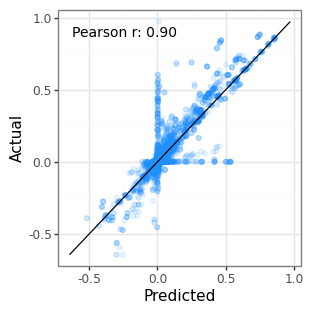

In [22]:
y_index = mod.y_out.index.tolist()
y_actual = y_test

Y_hat_test, Y_full_test, Y_fullFull_test, Y_fullprotein_test = mod(X_test, X_cell_test, missing_node_indexes)

#time_points = [int(idx.rsplit('_', 1)[-1]) for idx in y_index]
#seen = set()
#unique_time_points = [x for x in time_points if not (x in seen or seen.add(x))]
#unique_time_points = np.linspace(0, 149, 8).astype(int)
#Y_subsampled = Y_fullFull_test[:, unique_time_points, :]
Y_subsampled = subsample_Y(Y_fullFull_test, floor_idx, ceil_idx, weight)

Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(8, len(X_test), mod.y_out.shape[1])
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

C:\Users\kanto\AppData\Local\Temp\ipykernel_27288\2694568389.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 15088 rows containing non-finite values.
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 15088 rows containing missing values.


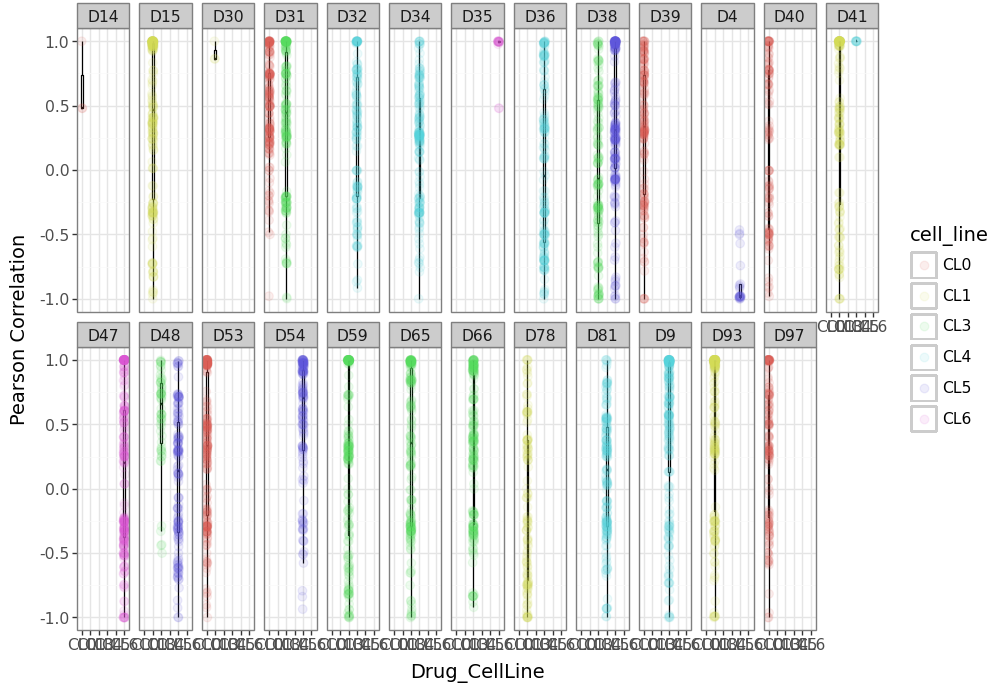

In [23]:
filtered_y_index = [idx for idx in mod.y_out.index.tolist() if idx not in y_train_index]
site_names = mod.y_out.columns.tolist()

meta = []
for i, index_str in enumerate(filtered_y_index):
    parts = index_str.split('_')
    
    drug, cell_line, time = parts[0], parts[1], float(parts[2])
    meta.append({'row': i, 'drug': drug, 'cell_line': cell_line, 'time': time})
meta_df = pd.DataFrame(meta)

y_pred_np = Y_subsampled.detach().cpu().numpy()
y_actual_np = y_actual.detach().cpu().numpy()

corr_list = []
n_sites = y_pred_np.shape[1]

# Group by both drug and cell_line
for (drug, cell_line), group in meta_df.groupby(['drug','cell_line']):
    # Skip DMSO samples as they will have correlation of 0
    if drug == "DMSO":
        continue
    # Get the list of row indices for this drug–cell line combination
    cell_rows = group['row'].tolist()
    
    # Loop over each phosphosite (i.e. each column)
    for site in range(n_sites):
        ts_pred = y_pred_np[cell_rows, site]
        ts_actual = y_actual_np[cell_rows, site]
        
        # Remove NaN values
        mask = (~np.isnan(ts_pred)) & (~np.isnan(ts_actual))
        ts_pred_valid = ts_pred[mask]
        ts_actual_valid = ts_actual[mask]
        
        if len(ts_pred_valid) > 1:
            r, _ = pearsonr(ts_pred_valid, ts_actual_valid)
            corr_list.append({
                'drug': drug,
                'cell_line': cell_line,
                'site': site,
                'correlation': r
            })

corr_df = pd.DataFrame(corr_list)
corr_df['sample'] = corr_df['drug'] + "_" + corr_df['cell_line']

# Plotting: similar to your sample-based plot, but now each point represents one phosphosite
plot_corr = (
    p9.ggplot(corr_df, p9.aes(x='cell_line', y='correlation', color='cell_line')) +
    p9.geom_boxplot(alpha=1, color='black', width=0.2, outlier_alpha=0) +
    p9.geom_jitter(position=p9.position_jitter(width=0.1, height=0),
                   size=3, alpha=0.1) +
    p9.scale_y_continuous(limits=(-1, 1)) +
    p9.labs(x="Drug_CellLine", y="Pearson Correlation") +
    p9.facet_wrap("~drug", nrow = 2) +
    p9.theme_bw(base_size=14) +
    p9.theme(figure_size=(10,7), legend_position='right')
)
plot_corr.draw()

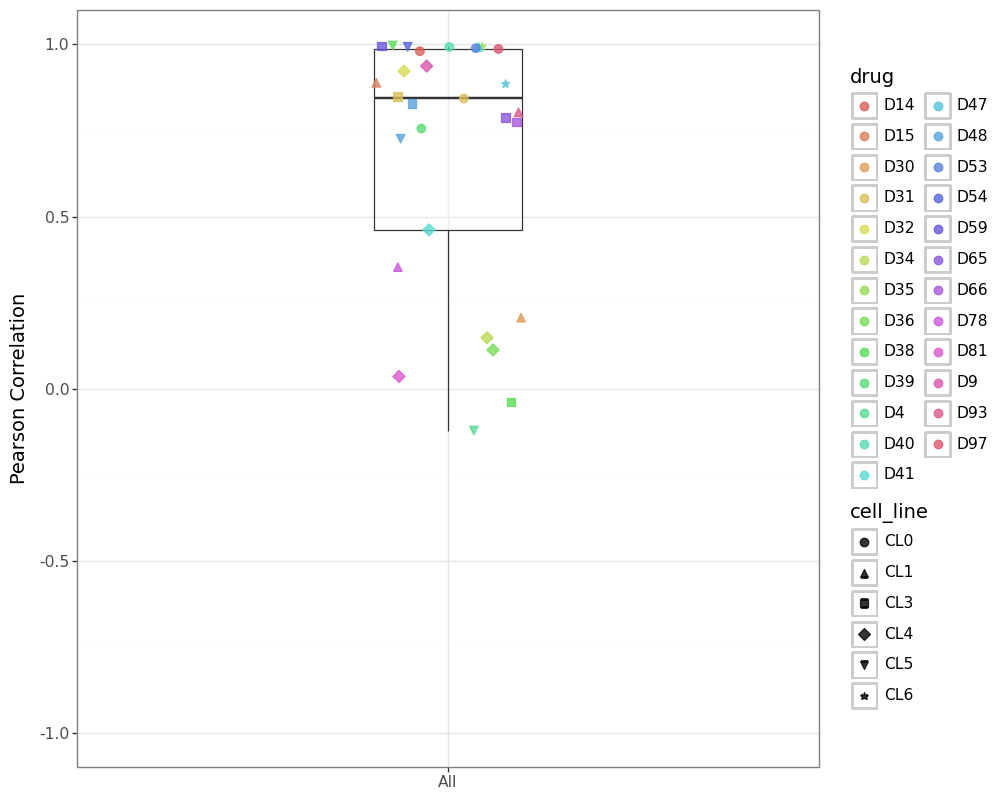

In [24]:
meta_df['sample'] = meta_df['drug'] + "_" + meta_df['cell_line']

# Compute the correlation for each sample (drug–cell_line combination)
corr_list = []
for sample, group in meta_df.groupby('sample'):
    # Get constant sample properties
    drug = group['drug'].iloc[0]
    # Skip DMSO samples as they will have correlation of 0
    if drug == "DMSO":
        continue
    
    cell_line = group['cell_line'].iloc[0]
    
    # Get the rows corresponding to all time points for this sample
    rows = group['row'].tolist()
    sample_ts_pred = y_pred_np[rows, :]    # shape: (n_time_points, n_sites)
    sample_ts_actual = y_actual_np[rows, :]
    ts_pred_flat = sample_ts_pred.flatten()
    ts_actual_flat = sample_ts_actual.flatten()
    
    # Remove NaN
    mask = (~np.isnan(ts_pred_flat)) & (~np.isnan(ts_actual_flat))
    ts_pred_valid = ts_pred_flat[mask]
    ts_actual_valid = ts_actual_flat[mask]
    
    if len(ts_pred_valid) > 1:
        r, _ = pearsonr(ts_pred_valid, ts_actual_valid)
        corr_list.append({
            'sample': sample,
            'drug': drug,
            'cell_line': cell_line,
            'correlation': r
        })

corr_df = pd.DataFrame(corr_list)
corr_df['x'] = 'All'

plot_corr = (
    p9.ggplot(corr_df, p9.aes(x='"All"', y='correlation'))
    + p9.geom_boxplot(alpha=0.3, width=0.2, outlier_alpha=0)
    + p9.geom_jitter(
          mapping=p9.aes(color='drug', shape='cell_line'),
          position=p9.position_jitter(width=0.1, height=0),
          size=3, alpha=0.8
      )
    + p9.scale_y_continuous(limits=(-1, 1))
    + p9.labs(x="", y="Pearson Correlation")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(10,8), legend_position='right')
)
plot_corr.draw()

torch.Size([480, 1073]) torch.Size([480, 1073])


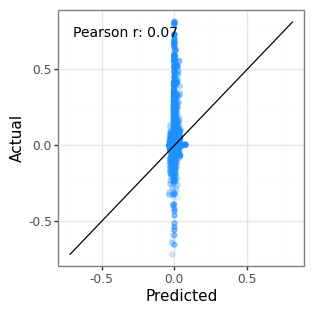

In [32]:
# Fix the x_data_val columns (drugs) to match the x_drug columns
x_data_val = x_data_val.reindex(columns=x_drug.columns, fill_value=0)

y_index = mod.y_out.index.tolist()
y_actual_val = mod.df_to_tensor(y_data_val)

X_val = mod.df_to_tensor(x_data_val)
X_cell_val = mod.df_to_tensor(x_cell_val)
Y_hat_val, Y_full_val, Y_fullFull_val, Y_fullprotein_val = mod(X_val, X_cell_val, missing_node_indexes)

#time_points = [int(idx.rsplit('_', 1)[-1]) for idx in y_index]
#seen = set()
#unique_time_points = [x for x in time_points if not (x in seen or seen.add(x))]
#unique_time_points = np.linspace(0, 149, 8).astype(int)
#Y_subsampled = Y_fullFull_test[:, unique_time_points, :]
Y_subsampled_val = subsample_Y(Y_fullFull_val, floor_idx, ceil_idx, weight)

Y_subsampled_val = Y_subsampled_val - Y_subsampled_val[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled_val = Y_subsampled_val.permute(1, 0, 2)
Y_subsampled_val = torch.flatten(Y_subsampled_val, start_dim=0, end_dim=1)

y_actual_val = y_actual_val.reshape(8, 60, mod.y_out.shape[1])
y_actual_val = y_actual_val - y_actual_val[0:1, :, :]  # Subtract the first time point from the actual data
y_actual_val = torch.flatten(y_actual_val, start_dim=0, end_dim=1)
print(Y_subsampled_val.shape, y_actual_val.shape)

y_pred_np = Y_subsampled_val.detach().flatten().cpu().numpy()
y_actual_np = y_actual_val.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

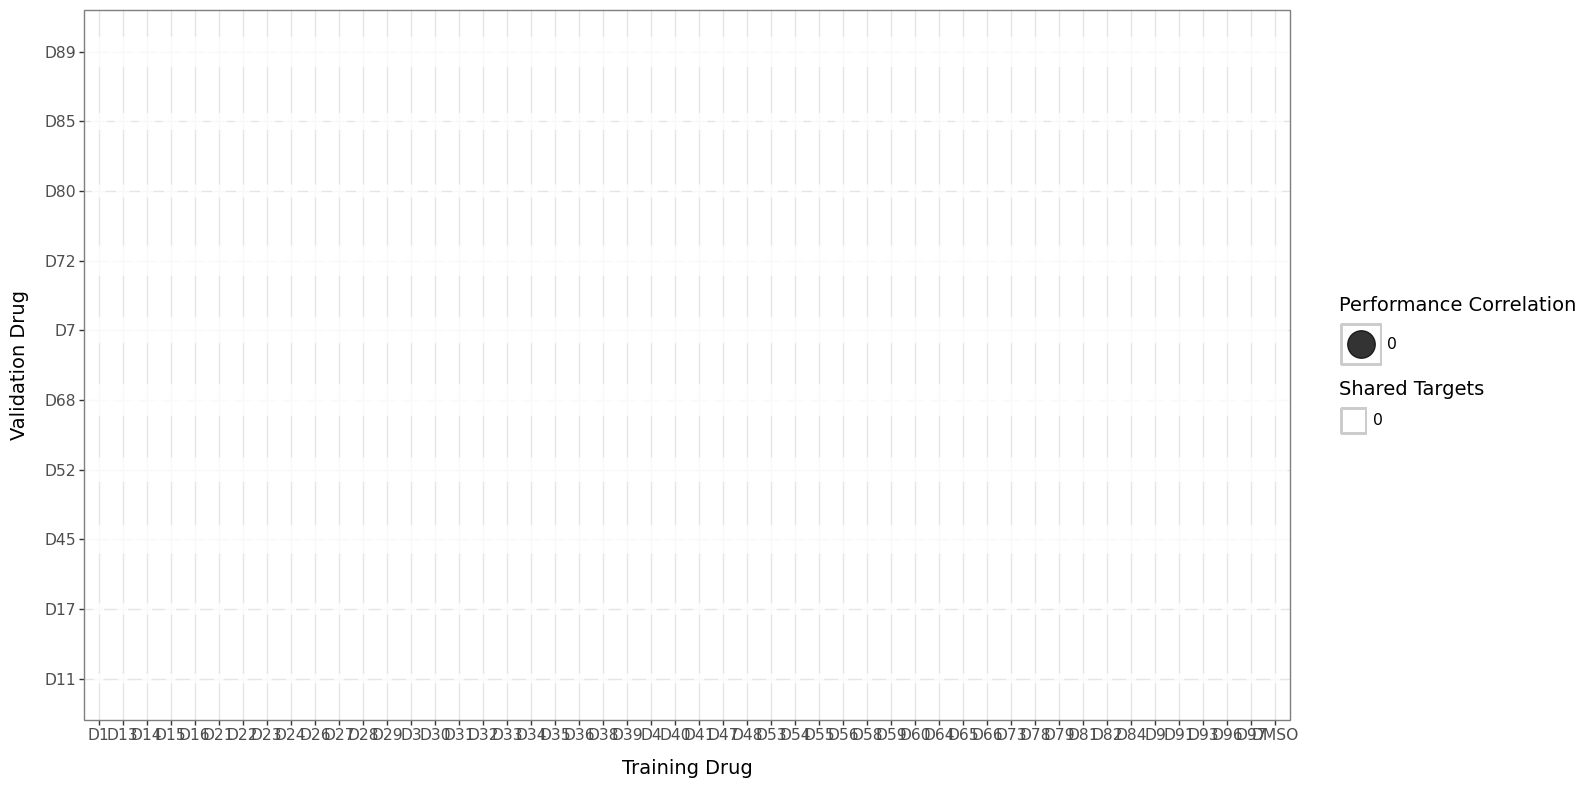

In [26]:
meta_train = pd.DataFrame({
    'row': range(len(x_data.index)),
    'drug': [idx.split('_')[0] for idx in x_data.index]
})
meta_val = pd.DataFrame({
    'row': range(len(x_data_val.index)),
    'drug': [idx.split('_')[0] for idx in x_data_val.index]
})

drugs_train = meta_train['drug'].unique()
drugs_val = meta_val['drug'].unique()

# Compute pairwise target overlap
pairwise_overlap_list = []

for dt in drugs_train:
    targets_train = set(x_drug.index[x_drug[dt] > 0]) if dt in x_drug.columns else set()
    for dv in drugs_val:
        targets_val = set(x_drug.index[x_drug[dv] > 0]) if dv in x_drug.columns else set()
        overlap_count = len(targets_train.intersection(targets_val))
        pairwise_overlap_list.append({
            'drug_train': dt,
            'drug_val': dv,
            'target_overlap': overlap_count
        })
pairwise_df = pd.DataFrame(pairwise_overlap_list)

meta = []
for i, index_str in enumerate(y_data_val.index):
    parts = index_str.split('_')
    drug, cell_line, time = parts[0], parts[1], float(parts[2])
    meta.append({'row': i, 'drug': drug, 'cell_line': cell_line, 'time': time})
meta_df = pd.DataFrame(meta)

y_pred_np = Y_subsampled_val.detach().cpu().numpy()
y_actual_np = y_actual_val.detach().cpu().numpy()

corr_list = []
for drug, group in meta_df.groupby('drug'):
    if drug == "DMSO":
        continue
    rows = group['row'].tolist()
    sample_ts_pred = y_pred_np[rows, :]
    sample_ts_actual = y_actual_np[rows, :]
    ts_pred_flat = sample_ts_pred.flatten()
    ts_actual_flat = sample_ts_actual.flatten()
    mask = (~np.isnan(ts_pred_flat)) & (~np.isnan(ts_actual_flat))
    if len(ts_pred_flat[mask]) > 1:
        r, _ = pearsonr(ts_pred_flat[mask], ts_actual_flat[mask])
        corr_list.append({'drug': drug, 'correlation': r})
corr_df = pd.DataFrame(corr_list)

pairwise_df = pairwise_df.merge(corr_df, left_on='drug_val', right_on='drug', how='left')
pairwise_df.rename(columns={'correlation': 'perf_corr'}, inplace=True)
pairwise_df.drop(columns=['drug'], inplace=True)
pairwise_df['target_overlap'] = pairwise_df['target_overlap'].astype('category')

my_colors = {0: "white", 1: "red"}

p_bubble = (
    p9.ggplot(pairwise_df, p9.aes(x='drug_train', y='drug_val', size='perf_corr', color='target_overlap')) +
    p9.geom_point(alpha=0.8) +
    p9.scale_size_continuous(
        range=(3, 12),
        breaks=[0.2, 0.4, 0.6, 0.8, 1],
        name='Performance Correlation'
    ) +
    p9.scale_color_manual(name='Shared Targets', values=my_colors) + 
    p9.labs(x='Training Drug', y='Validation Drug') +
    p9.theme_bw(base_size=14) +
    p9.theme(figure_size=(16, 8), legend_position='right')
)

p_bubble.draw()

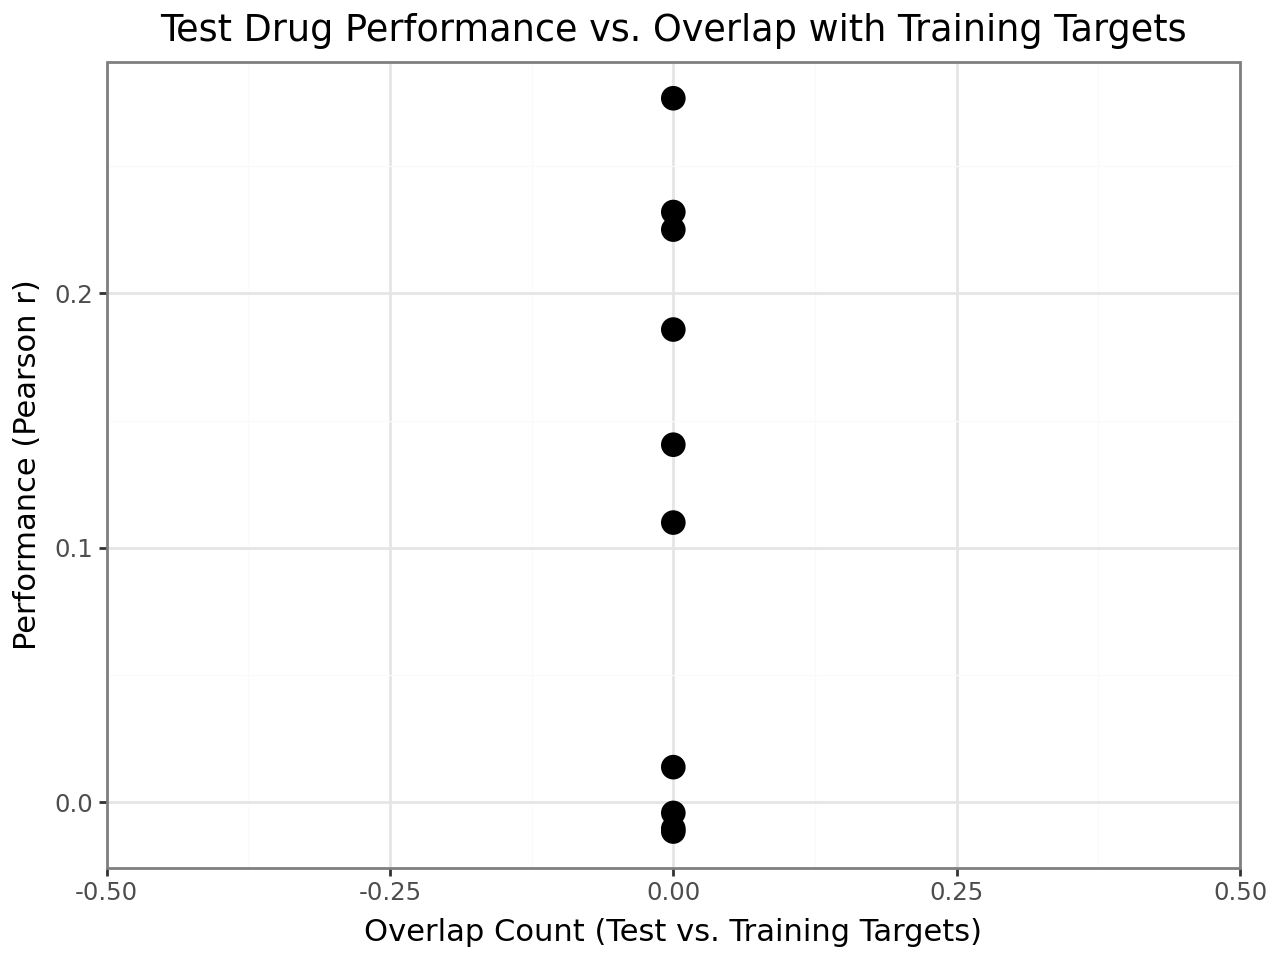

C:\Users\kanto\AppData\Local\Temp\ipykernel_27288\3891944387.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


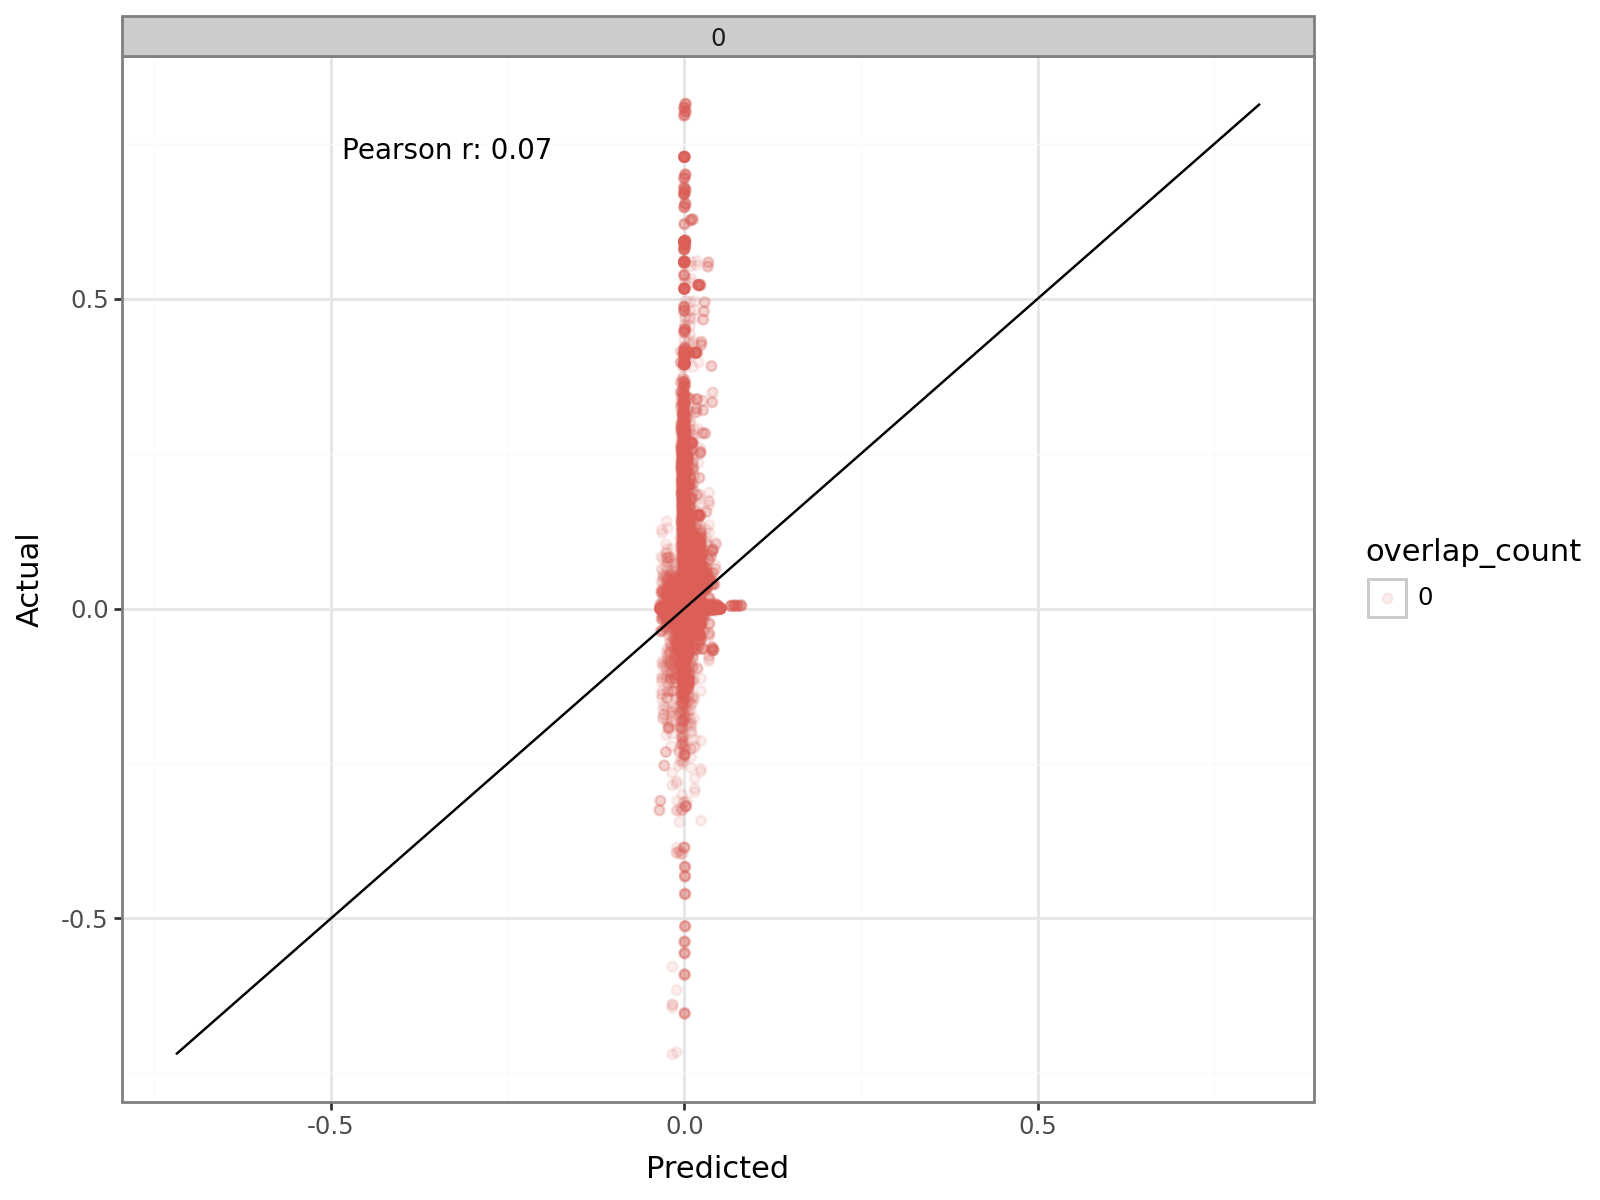

In [27]:
training_drugs = np.unique([idx.split('_')[0] for idx in y_data.index])
common_train = [drug for drug in training_drugs if drug in x_drug.columns]
train_target_union = (x_drug[common_train] > 0).any(axis=1)

test_drugs = np.unique([idx.split('_')[0] for idx in y_data_val.index])
common_test = [drug for drug in test_drugs if drug in x_drug.columns]

overlap_list = []
for drug in common_test:
    test_targets = (x_drug[drug] > 0)  # boolean series per target for current test drug
    overlap_count = (test_targets & train_target_union).sum()
    total_targets = test_targets.sum()
    overlap_ratio = overlap_count / total_targets if total_targets > 0 else 0
    overlap_list.append({
        'drug': drug,
        'overlap_count': overlap_count,
        'overlap_ratio': overlap_ratio
    })
overlap_df = pd.DataFrame(overlap_list)


meta_test = []
for i, index_str in enumerate(y_data_val.index):
    drug = index_str.split('_')[0]
    meta_test.append({'row': i, 'drug': drug})
meta_test_df = pd.DataFrame(meta_test)

test_corr_list = []
for drug, group in meta_test_df.groupby('drug'):
    rows = group['row'].tolist()
    # Use the predictions and actuals from the test set
    pred_vals = y_pred_np[rows]
    actual_vals = y_actual_np[rows]
    mask = (~np.isnan(pred_vals)) & (~np.isnan(actual_vals))
    if mask.sum() > 1:
        r, _ = pearsonr(pred_vals[mask], actual_vals[mask])
    else:
        r = np.nan
    test_corr_list.append({'drug': drug, 'correlation': r})
test_corr_df = pd.DataFrame(test_corr_list)


plot_df = overlap_df.merge(test_corr_df, on='drug')

p = (p9.ggplot(plot_df, p9.aes(x='overlap_count', y='correlation'))
     + p9.geom_point(size=4)
     + p9.labs(
         x='Overlap Count (Test vs. Training Targets)',
         y='Performance (Pearson r)',
         title='Test Drug Performance vs. Overlap with Training Targets'
     )
     + p9.theme_bw()
)
p.show()

mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

num_repeats = len(y_pred_np) // len(meta_test_df)
meta_test_ext = pd.DataFrame(
    np.repeat(meta_test_df.values, num_repeats, axis=0),
    columns=meta_test_df.columns
)

viz_df = pd.DataFrame(data={'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
viz_df['drug'] = meta_test_df.loc[mask, 'drug'].values

# Merge in the overlap information
viz_df = viz_df.merge(overlap_df[['drug', 'overlap_count']], on='drug', how='left')
viz_df['overlap_count'] = viz_df['overlap_count'].astype('category')

# Compute Pearson r for annotation
cor_list = []
for cat, group in viz_df.groupby('overlap_count'):
    pr_cat, _ = pearsonr(group['Predicted'], group['Actual'])
    cor_list.append({
        'overlap_count': cat,
        'label': f'Pearson r: {pr_cat:.2f}'
    })
cor_df = pd.DataFrame(cor_list)

min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 8, 6
p2 = (
    p9.ggplot(viz_df, p9.aes(x='Predicted', y='Actual', color='overlap_count')) +
    p9.geom_point(alpha=0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.scale_color_discrete() +
    p9.facet_wrap('~ overlap_count', nrow=2) +
    p9.theme_bw() +
    p9.theme(figure_size=(width, height)) +
    p9.geom_text(
        data=cor_df,
        mapping=p9.aes(
            x=min_val + 0.25 * (max_val - min_val),
            y=max_val - 0.05 * (max_val - min_val),
            label='label'
        ),
        size=10,
        color='black',
        inherit_aes=False
    )
)
p2.show()

In [28]:
drug_input = "D42"
cl_input = "CL0"
phosphosite_input = "Q13233_site_1"  # Q16539, P35568, P05412, Q13233 
x_values = [0, 1, 2, 3, 5, 10, 20, 50]  #list(range(150))  [0, 2 , 5, 12, 28, 64, 149]  [0, 3, 6, 9, 12, 15, 18, 21]  [0, 1, 2, 3, 5, 10, 20, 50]
Y_plot = Y_fullFull[:, x_values, :]
y_out = mod.df_to_tensor(mod.y_out)

#Y_plot = subsample_Y(Y_fullFull, floor_idx, ceil_idx, weight)
Y_plot = Y_plot.permute(1, 0, 2)
Y_plot = torch.flatten(Y_plot, start_dim=0, end_dim=1)

# Prepare the Y_actual
y_actual = y_data.reset_index().rename(columns={"index": "Drug_CL_Time"})

y_actual[['Drug', 'CL', 'Time']] = y_actual['Drug_CL_Time'].str.split('_', expand=True)
y_actual['Time'] = y_actual['Time'].astype(int)

df_cell = y_actual[y_actual['CL'] == cl_input].copy()
df_drug = y_actual[y_actual['Drug'] == drug_input].copy()

df_cell['Group'] = df_cell['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug['Group'] = df_drug['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})

# Sort the DataFrames by time for clarity.
df_cell = df_cell.sort_values(by=['Drug', 'CL', 'Time'])
df_drug = df_drug.sort_values(by=['Drug', 'CL', 'Time'])

cell_conditions = df_cell['Drug_CL_Time'].tolist()
drug_conditions = df_drug['Drug_CL_Time'].tolist()

cell_indices = [y_data.index.get_loc(cond) for cond in cell_conditions]
drug_indices = [y_data.index.get_loc(cond) for cond in drug_conditions]

phosphosite_idx = y_data.columns.get_loc(phosphosite_input)

# For the cell subset:
Y_cell_site = Y_plot[cell_indices, phosphosite_idx]

Drug, CL, Time = zip(*[cond.split('_') for cond in cell_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_cell_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_cell_site.detach().cpu().numpy(),
    'Drug': Drug
})

# For the drug subset:
Y_drug_site = Y_plot[drug_indices, phosphosite_idx]

Drug, CL, Time = zip(*[cond.split('_') for cond in drug_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_drug_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_drug_site.detach().cpu().numpy(),
    'CL': CL
})

# Create the actual data
df_cell = df_cell[df_cell['Drug_CL_Time'].isin(cell_conditions)]
df_cell["Train/Test"] = df_cell["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_cell = df_cell[['Time', phosphosite_input, 'Drug', "Train/Test"]]
df_cell = df_cell.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_cell["Group"] = "Actual"

df_drug = df_drug[df_drug['Drug_CL_Time'].isin(drug_conditions)]
df_drug["Train/Test"] = df_drug["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug = df_drug[['Time', phosphosite_input, 'CL', "Train/Test"]]
df_drug = df_drug.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_drug["Group"] = "Actual"

df_cell_pred['Train/Test'] = df_cell['Train/Test'].reset_index(drop=True)
df_cell_pred['Group'] = "Predicted"
df_drug_pred['Train/Test'] = df_drug['Train/Test'].reset_index(drop=True)
df_drug_pred['Group'] = "Predicted"

df_cell_plot = pd.concat([df_cell, df_cell_pred], axis=0)
df_drug_plot = pd.concat([df_drug, df_drug_pred], axis=0)

# Plot A: Facet by Drug (for the specified cell line)
plot_A = (
    p9.ggplot(df_cell_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ Drug')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 'x'})
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Drug, Cell Line: {cl_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_A.show()

# Plot B: Facet by Cell Line (for the specified drug)
plot_B = (
    p9.ggplot(df_drug_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ CL')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 'x'})
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Cell Line, Drug: {drug_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_B.show()


ValueError: not enough values to unpack (expected 3, got 0)